In [2]:
from Utils import load_results, loadBestKnown
import numpy as np

In [3]:
bk_solutions = {f"j30{i//10 + 1}_{(i%10)+1}": makespan for i, makespan in enumerate(loadBestKnown(30))}
bk_solutions = {f"j60{i//10 + 1}_{(i%10)+1}": makespan for i, makespan in enumerate(loadBestKnown(60))} | bk_solutions
bk_solutions = {f"j120{i//10 + 1}_{(i%10)+1}": makespan for i, makespan in enumerate(loadBestKnown(120))} | bk_solutions

In [4]:
def calculate_auc(values):
    """
    Calculate the Area Under the Curve (AUC) using the trapezoidal rule.
    
    Parameters:
        values (list of int or float): Sequence of performance values over time.
        
    Returns:
        float: Area under the curve.
    """
    if not values or len(values) < 2:
        return 0.0

    auc = 0.0
    for i in range(1, len(values)):
        # Trapezoid area between two points: (y1 + y2) / 2 * delta_x
        auc += (values[i-1] + values[i]) / 2  # delta_x assumed to be 1

    return auc

In [5]:
def desviations(filename: str, cycles=None):
    results = load_results(filename=filename)
    results = sorted(results, key=lambda x: x.problem_id)
    if cycles is None:
        return np.array([result.best.makespan - bk_solutions[result.problem_id] for result in results])
    return np.array([result.best_history[:cycles+1][-1] - bk_solutions[result.problem_id] for result in results])
    

def auc_data(filename: str, cycles=None):
    results = load_results(filename=filename)
    results = sorted(results, key=lambda x: x.problem_id)
    if cycles is None:
        return np.array([calculate_auc(result.best_history) for result in results])
    return np.array([calculate_auc(result.best_history[:cycles]) for result in results])

In [15]:
def print_results(filename: str):
    results = load_results(filename=filename)
    cycles = np.array([len(result.best_history) for result in results])
    print(filename.upper())
    print("---------------------------")
    print(f"Average number of cycles: {np.average(cycles)}")
    print(f"Standar desviation: {np.std(cycles)}")
    print(f"Minimum cycles: {np.min(cycles)}")
    print(f"Maximum cycles: {np.max(cycles)}")
    print("")
    data = desviations(filename=filename)
    print(f"Average number of desviation: {np.average(data)}")
    print(f"Standar desviation (of desviations): {np.std(data)}")
    print(f"Minimum desviation: {np.min(data)}")
    print(f"Maximum desviation: {np.max(data)}")
    print("---------------------------")
    print("")

In [7]:
from scipy.stats import kstest, norm, wilcoxon
import numpy as np

def isNormalDistribution(samples):
    data = np.array(samples)
    stat, p = kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"K-S Test: Statistic={stat}, p-value={p}")
    if p > 0.05:
        print("Data looks Gaussian")
    else:
        print("Data does NOT look Gaussian")


def wilcoxon_ranked_test(d1, d2):
    model1_scores = np.array(d1)
    model2_scores = np.array(d2)

    # Run Wilcoxon signed-rank test
    stat, p = wilcoxon(model1_scores, model2_scores)

    print(f"Wilcoxon Test: Statistic={stat}, p-value={p}")
    if p < 0.05:
        print("Significant difference between the two models")
    else:
        print("No significant difference between the two models")


In [16]:
print_results(filename="Results/j30-N17-L125-P45-S15.json")

Results successfully loaded from Results/j30-N17-L125-P45-S15.json
RESULTS/J30-N17-L125-P45-S15.JSON
---------------------------
Average number of cycles: 357.64
Standar desviation: 562.2713494390409
Minimum cycles: 4
Maximum cycles: 1472

Results successfully loaded from Results/j30-N17-L125-P45-S15.json
Average number of desviation: 0.26
Standar desviation (of desviations): 0.5936328831862332
Minimum desviation: 0
Maximum desviation: 2
---------------------------



In [364]:
dataset = "j120"
filename1 = f"Results/{dataset}-random-init-abc.json"
filename2 = f"Results/{dataset}-mcmc-init-abc.json"
data1 = desviations(filename=filename1)
data2 = desviations(filename=filename2)
convergence1 = auc_data(filename=filename1)
convergence2 = auc_data(filename=filename2)

Results successfully loaded from Results/j120-random-init-abc.json
Results successfully loaded from Results/j120-mcmc-init-abc.json
Results successfully loaded from Results/j120-random-init-abc.json
Results successfully loaded from Results/j120-mcmc-init-abc.json


In [365]:
data1 = convergence1/10000
data2 = convergence2/10000

In [186]:
from autorank import create_report, autorank
import pandas as pd
print(np.average(data1), np.std(data1))
print(np.average(data2), np.std(data2))

isNormalDistribution(data1)
isNormalDistribution(data2)
wilcoxon_ranked_test(data1, data2)
dt = pd.DataFrame({
    filename1: data1,
    filename2: data2
})

result = autorank(dt)

print(create_report(result))

# j30: 0.0649
# j60: 2.9693e-31
# j120: 1.7190e-68

5.245833333333334 4.878736103974289
4.908333333333333 4.784080952027836
K-S Test: Statistic=0.15652733004364228, p-value=9.746956573003813e-11
Data does NOT look Gaussian
K-S Test: Statistic=0.15962937531377408, p-value=3.755091675511065e-11
Data does NOT look Gaussian
Wilcoxon Test: Statistic=14494.5, p-value=1.6695687359483045e-06
Significant difference between the two models
                                  meanrank  median  mad ci_lower ci_upper  \
Results/j60-gsabc.json            1.584375     4.0  4.0        2        5   
Results/j60-random-init-abc.json  1.415625     4.0  4.0        3        5   

                                 effect_size   magnitude effect_size_above  \
Results/j60-gsabc.json                   0.0  negligible               0.0   
Results/j60-random-init-abc.json         0.0  negligible               0.0   

                                 magnitude_above  
Results/j60-gsabc.json                negligible  
Results/j60-random-init-abc.json      negligible  

In [346]:
cycles = np.arange(1, 1470, 5)
auc_evolution = []
for cycle in cycles:
    auc1 = auc_data(filename=filename1, cycles=cycle)
    auc2 = auc_data(filename=filename2, cycles=cycle)
    auc_evolution.append((auc1, auc2))

Results successfully loaded from Results/j120-random-init-abc.json
Results successfully loaded from Results/j120-mcmc-init-abc.json
Results successfully loaded from Results/j120-random-init-abc.json
Results successfully loaded from Results/j120-mcmc-init-abc.json
Results successfully loaded from Results/j120-random-init-abc.json
Results successfully loaded from Results/j120-mcmc-init-abc.json
Results successfully loaded from Results/j120-random-init-abc.json
Results successfully loaded from Results/j120-mcmc-init-abc.json
Results successfully loaded from Results/j120-random-init-abc.json
Results successfully loaded from Results/j120-mcmc-init-abc.json
Results successfully loaded from Results/j120-random-init-abc.json
Results successfully loaded from Results/j120-mcmc-init-abc.json
Results successfully loaded from Results/j120-random-init-abc.json
Results successfully loaded from Results/j120-mcmc-init-abc.json
Results successfully loaded from Results/j120-random-init-abc.json
Results s

In [347]:
auc_evolution = np.array(auc_evolution)
auc_evolution_avg = np.average(auc_evolution, axis=2)
print(auc_evolution_avg.shape)

(294, 2)


In [348]:
pvalues = []
for samples in auc_evolution:
    data1 = samples[0]
    data2 = samples[1]
    pvalues.append(wilcoxon(data1, data2)[1])

/Users/pablofornetmartin/miniconda3/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:178: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


In [349]:
print(auc_evolution_avg[0])
p_values = np.array(pvalues)

[0. 0.]


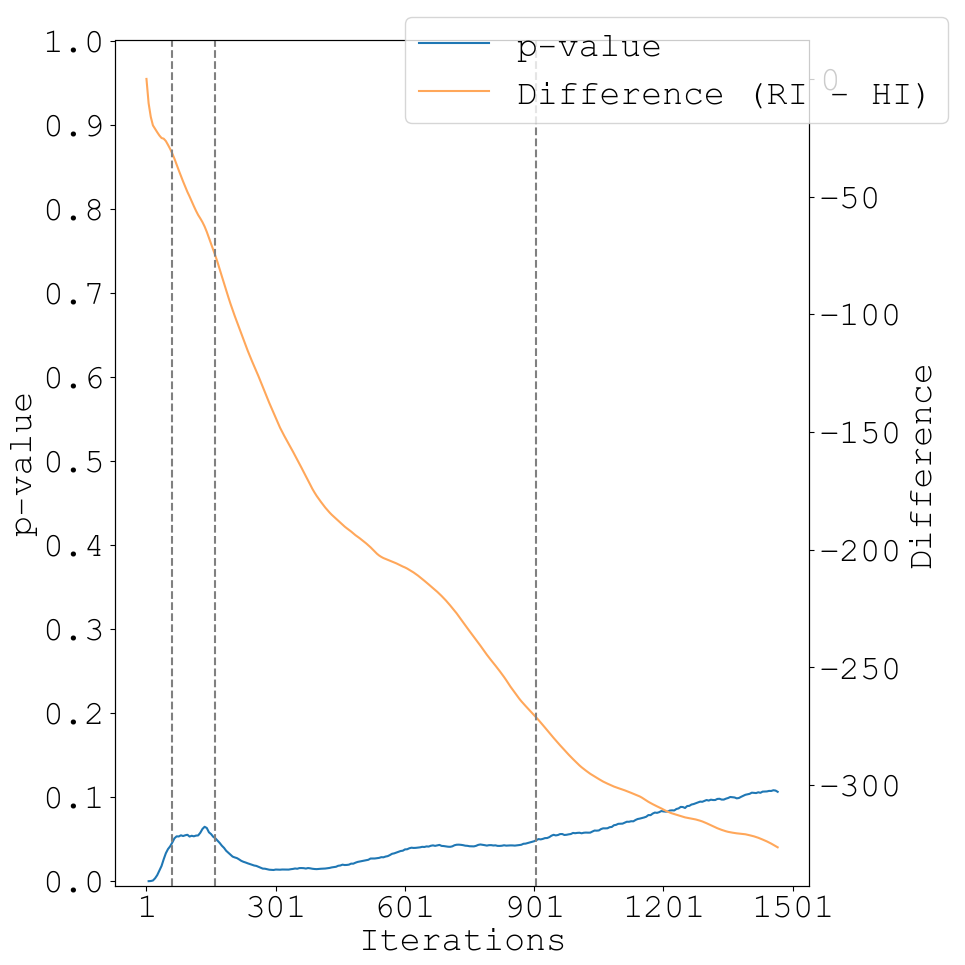

In [351]:
import matplotlib.pyplot as plt
# Sample data
x = cycles
y1 = [d[0]-d[1] for d in auc_evolution_avg]      # First dataset
# y2 = [d[1] for d in auc_evolution_avg]  # Second dataset

threshold = 0.05
diff = p_values - threshold
crossings = np.where(np.diff(np.sign(diff)))[0]

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 10))

color1 = '#1f77b4'  # blue from Tableau palette
color2 = "#ffa75a"  # orange from Tableau palette

# Plot the first dataset
ax1.plot(x, p_values, label='p-value', color=color1)
# ax1.plot(x, y2, label='ABC con búsqueda local', color=color2)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('p-value')
ax1.set_yticks(np.arange(0.0, 1.1, 0.1))
ax1.tick_params(axis='y')
ax1.set_xticks(np.arange(1, 1502, 300))

ax2 = ax1.twinx()
ax2.plot(x, y1, color=color2, label='Difference (RI - HI)')
# ax2.plot(x, y3, color=color3, label='heuristic AUC')
ax2.set_ylabel('Difference')
ax2.tick_params(axis='y')

for cross in crossings[1:-2]:
    plt.axvline(x=cross*5, linestyle='--', color='gray')

fig.legend()
plt.tight_layout()
# Show the plot
# plt.title("Population diversity")
plt.savefig(f"../Assets/{dataset}-init-diff.pdf")
plt.show()

# print(crossings)

Number of zero differences: 54 out of 480


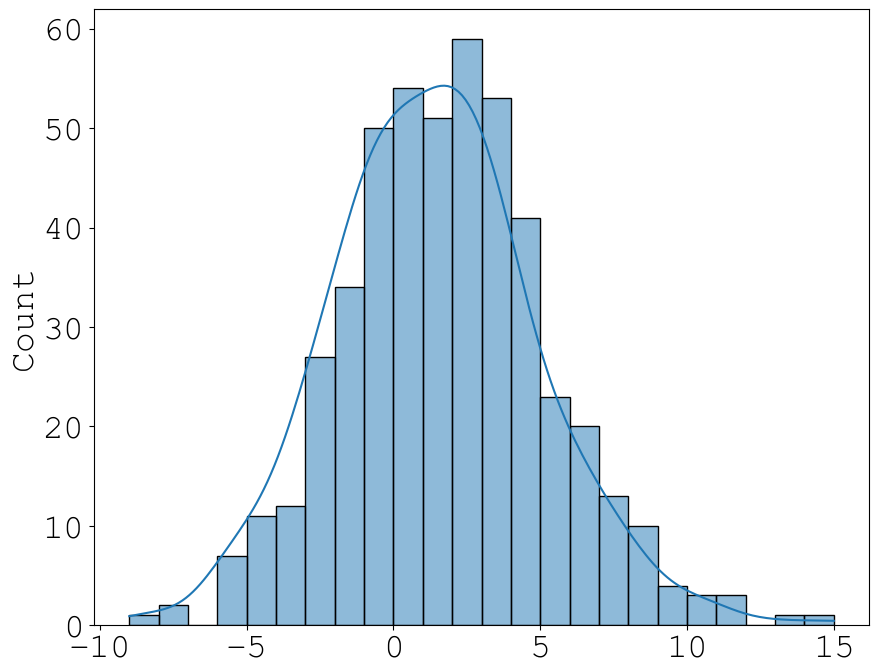

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

FONT_SIZE =25
    
plt.rcParams.update({
    'font.family': 'Courier New',
    'font.size': FONT_SIZE,
    'axes.titlesize': FONT_SIZE,
    'axes.labelsize': FONT_SIZE,
    'xtick.labelsize': FONT_SIZE,
    'ytick.labelsize': FONT_SIZE,
    'figure.titlesize': FONT_SIZE
})

differences = np.array(data1) - np.array(data2)
num_zeros = np.sum(differences == 0)

print(f"Number of zero differences: {num_zeros} out of {len(differences)}")

differences = [a - b for a, b in zip(data1, data2)]
plt.figure(figsize=(10, 8))
sns.histplot(differences, kde=True)
# plt.title("Distribution of Pairwise Differences")
plt.show()

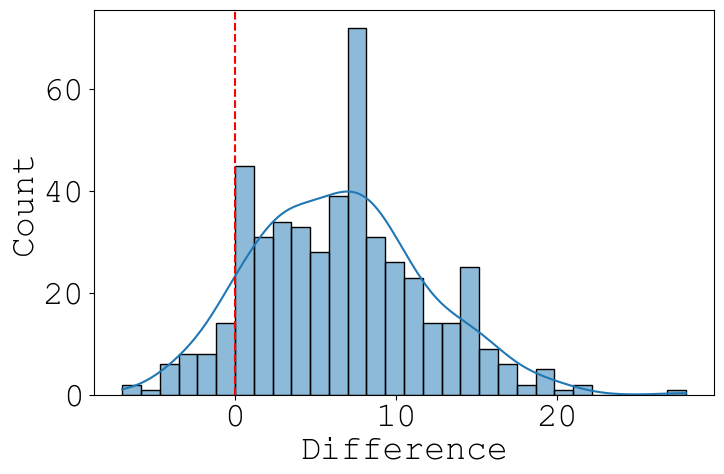

In [252]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

differences = np.array(data1) - np.array(data2)

plt.figure(figsize=(8, 5))
sns.histplot(differences, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Difference")
plt.show()


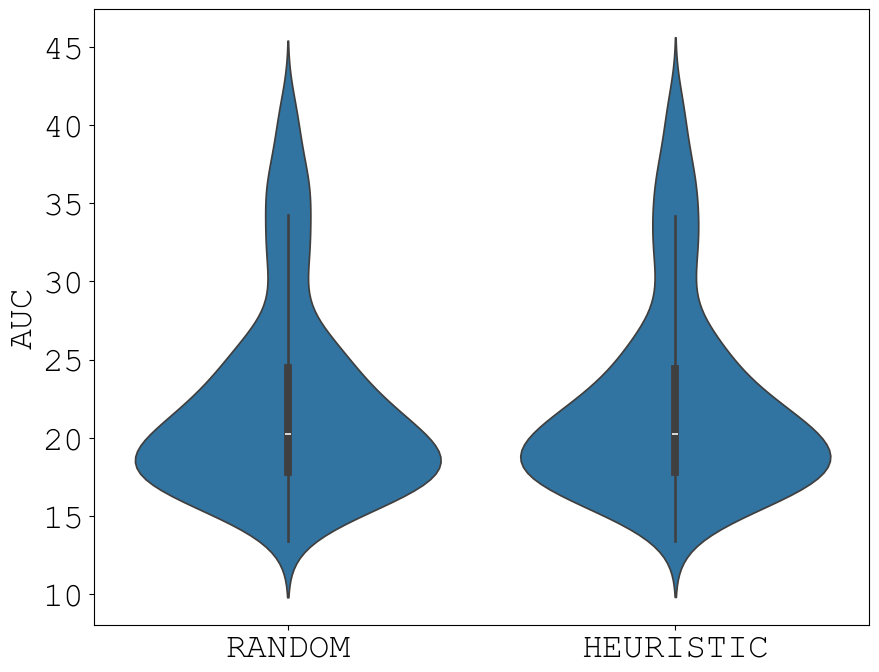

In [366]:
import pandas as pd

df = pd.DataFrame({
    "RANDOM": data1,
    "HEURISTIC": data2
})

df_melted = df.melt(var_name="", value_name="AUC")

plt.figure(figsize=(10, 8))
sns.violinplot(x="", y="AUC", data=df_melted, inner="box")
plt.savefig(f"../Assets/violin-auc-init-{dataset}.pdf")
plt.show()

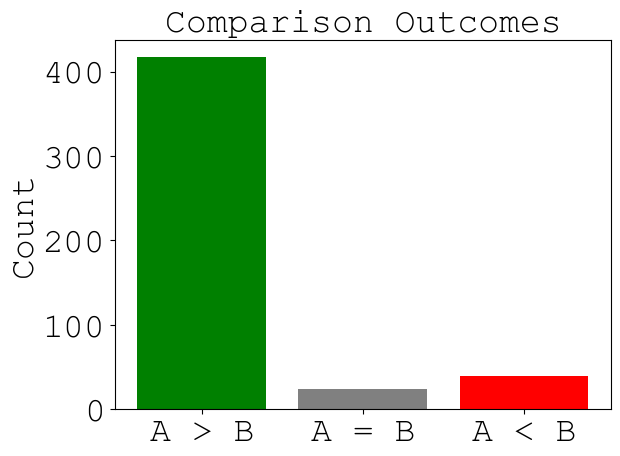

In [ ]:
a = np.array(data1)
b = np.array(data2)
diffs = a - b

counts = {
    "A > B": np.sum(diffs > 0),
    "A = B": np.sum(diffs == 0),
    "A < B": np.sum(diffs < 0)
}

plt.bar(counts.keys(), counts.values(), color=["green", "gray", "red"])
plt.title("Comparison Outcomes")
plt.ylabel("Count")
plt.show()

In [239]:
data = load_results(filename="Results/j120-local-search-abc.json")

Results successfully loaded from Results/j120-local-search-abc.json


In [240]:
last_change = []
data.reverse()
for instance in data:
    last = 0
    if len(instance.best_history) < 1400:
        continue
    for i, x in enumerate(instance.best_history):
        if x > instance.best.makespan:
            last = i
    last_change.append(last)

print(last_change)
print(f"Last change in best solution: {np.average(last_change)} iterations")


[0, 350, 83, 0, 0, 125, 512, 154, 105, 263, 247, 240, 611, 90, 690, 86, 804, 89, 56, 1171, 67, 1300, 178, 231, 751, 503, 95, 266, 1, 214, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 150, 0, 0, 0, 0, 849, 117, 0, 35, 0, 0, 0, 0, 0, 1, 0, 539, 0, 1413, 1, 215, 1098, 534, 0, 110, 0, 142, 1, 396, 0, 0, 0, 1, 922, 109, 0, 768, 0, 1180, 0, 1, 0, 1, 1317, 1183, 0, 0, 1297, 0, 0, 654, 834, 1449, 0, 0, 1315, 0, 566, 124, 88, 262, 0, 430, 119, 1, 2, 157, 116, 252, 1197, 136, 130, 286, 232, 193, 66, 174, 926, 95, 178, 43, 705, 166, 207, 464, 630, 576, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 45, 0, 234, 0, 318, 272, 1085, 224, 1358, 1065, 143, 79, 151, 0, 0, 116, 134, 151, 1031, 87, 74, 1375, 111, 1460, 321, 827, 381, 101, 847, 518, 219, 740, 459, 63, 145, 114, 307, 1, 3, 2, 181, 0, 1, 2, 0, 0, 0, 406, 1, 163, 0, 134, 0, 1, 1, 1, 418, 769, 129, 0, 0, 1376, 0, 145, 132, 146, 103, 232, 1, 1376, 1087, 71, 1211, 108, 619, 229, 171, 103, 926, 862, 59, 76, 981, 1169, 1267, 112, 802, 0, 0, 0, 0, 0, 0, 0, 0, 0,